In [1]:
import numpy as np
np.set_printoptions(precision=4)
from pathlib import Path
import mujoco
import matplotlib.pyplot as plt
import logging
from scipy.spatial import ConvexHull, convex_hull_plot_2d, QhullError
import itertools
import pandas as pd
import cvxopt as cvx
import sys

In [2]:
# contact_data_dir = "04042024-131547" # cube
contact_data_dir = "04042024-143722" # cloth

In [3]:
def cvx_vol(all_coordinates):
    try:
        hull = ConvexHull(all_coordinates)
        return hull.volume, True    
    except (QhullError, ValueError):
        return 0.0, False

In [4]:
def wrench_rank(wrenches):
    try:
        return np.linalg.matrix_rank(wrenches)
    except ValueError:
        return 0

In [5]:
def wrench_volume(forces):
    return ConvexHull(forces.T).volume

In [6]:
# This code is adapted from DexNet at https://github.com/BerkeleyAutomation/dex-net/blob/master/src/dexnet/grasping/quality.py#L670

def min_norm_vector_in_facet(facet, wrench_regularizer=1e-10):
        dim = facet.shape[1] # num vertices in facet

        # create alpha weights for vertices of facet
        G = facet.T.dot(facet)
        grasp_matrix = G + wrench_regularizer * np.eye(G.shape[0])

        # Solve QP to minimize .5 x'Px + q'x subject to Gx <= h, Ax = b
        P = cvx.matrix(2 * grasp_matrix)   # quadratic cost for Euclidean dist
        q = cvx.matrix(np.zeros((dim, 1)))
        G = cvx.matrix(-np.eye(dim))       # greater than zero constraint
        h = cvx.matrix(np.zeros((dim, 1)))
        A = cvx.matrix(np.ones((1, dim)))  # sum constraint to enforce convex
        b = cvx.matrix(np.ones(1))         # combinations of vertices

        sol = cvx.solvers.qp(P, q, G, h, A, b)
        v = np.array(sol['x'])
        min_norm = np.sqrt(sol['primal objective'])

        return abs(min_norm), v

def epsilon(wrenches, wrench_norm_thresh=20, wrench_regularizer=1e-10):
    G = wrenches

    try:
        hull = ConvexHull(wrenches.T)
    
        if len(hull.simplices) == 0:
            print('Convex hull could not be computed')
            return 0.0, False, 'Convex hull could not be computed'
    
        # determine whether or not zero is in the convex hull
        min_norm_in_hull, v = min_norm_vector_in_facet(G, wrench_regularizer=wrench_regularizer)
    
        print(f"min_norm_in_hull: {min_norm_in_hull} -- v:{v}")
        
        # if norm is greater than 0 then forces are outside of hull
        if min_norm_in_hull > wrench_norm_thresh:
            print('Zero not in convex hull')
            return 0.0, False, 'Zero not in convex hull'
    
        # if there are fewer nonzeros than D-1 (dim of space minus one)
        # then zero is on the boundary and therefore we do not have
        # force closure
        if np.sum(v > 1e-4) <= G.shape[0]-1:
            print('Zero not in interior of convex hull')
            return 0.0, False, 'Zero not in interior of convex hull'
    
        # find minimum norm vector across all facets of convex hull
        min_dist = sys.float_info.max
        closest_facet = None
        for v in hull.simplices:
            if np.max(np.array(v)) < G.shape[1]: # because of some occasional odd behavior from pyhull
                facet = G[:, v]
                dist, _ = min_norm_vector_in_facet(facet, wrench_regularizer=wrench_regularizer)
                if dist < min_dist:
                    min_dist = dist
                    closest_facet = v
        return min_dist, True, "Success"
    except (QhullError, ValueError) as e:
        return 0.0, False, e

In [19]:
axes = ["x", "y"]
angles = np.arange(-np.pi/6, np.pi/6+np.pi/18, step=np.pi/18)
# cloth_names = [0]
cloth_names = [25]
column_names = ["cloth", "axis", "angle", "num_points", "points_cvx_vol", 
                "points_cvx_vol_exists", "wrench_rank", "wench_vol", 'eps']
data = []
for cloth_name in cloth_names:
    angles = np.rad2deg(np.arange(-np.pi/6, np.pi/6+np.pi/18, step=np.pi/18))
    combinations = itertools.product(['x', 'y'], angles)
    combinations = [(ax, ang) for ax, ang in combinations if ax == 'x' or ang != 0]
    for (axis, angle) in combinations:
        angle = f"{angle:.0f}"
        file_path = Path(contact_data_dir) / f"{cloth_name}_{axis}_{angle}.npy"
        contacts = np.load(file_path,allow_pickle='TRUE').item()
        all_coordinates = contacts['pos']
        cvx_volume, cvx_volume_success = cvx_vol(all_coordinates)
        wrench_vol = wrench_volume(contacts['forces'])
        e = epsilon(contacts['forces'])
        data.append([cloth_name, axis, angle, len(all_coordinates),
                            cvx_volume, cvx_volume_success, wrench_rank(contacts['forces']), wrench_vol, e[0]])

     pcost       dcost       gap    pres   dres
 0:  1.3573e-02 -1.0045e+00  3e+01  6e+00  6e+00
 1:  4.6417e-02 -9.1819e-01  1e+00  9e-16  2e-15
 2:  4.0274e-02 -3.1086e-02  7e-02  2e-16  2e-15
 3:  1.2929e-02 -1.1729e-02  2e-02  2e-16  7e-16
 4:  6.1555e-03  2.5749e-03  4e-03  4e-17  9e-16
 5:  3.7489e-03  3.3735e-03  4e-04  8e-17  8e-16
 6:  3.4277e-03  3.4224e-03  5e-06  1e-16  1e-15
 7:  3.4229e-03  3.4228e-03  5e-08  8e-17  1e-15
Optimal solution found.
min_norm_in_hull: 0.058505325168315414 -- v:[[3.9081e-08]
 [8.5431e-08]
 [3.7635e-01]
 [1.4219e-06]
 [7.5152e-08]
 [3.7909e-08]
 [3.3129e-08]
 [6.3057e-08]
 [2.9722e-07]
 [2.7473e-07]
 [6.1034e-08]
 [3.2919e-08]
 [3.1628e-08]
 [3.6383e-08]
 [7.2708e-08]
 [3.1311e-07]
 [1.4225e-07]
 [4.9201e-08]
 [3.7002e-08]
 [4.0991e-08]
 [8.9356e-08]
 [4.2681e-01]
 [6.1789e-07]
 [6.4357e-08]
 [4.3133e-08]
 [1.2290e-07]
 [1.9683e-01]
 [2.3633e-07]
 [5.2547e-08]
 [3.3762e-08]]
Zero not in interior of convex hull
     pcost       dcost       gap   

In [8]:
df = pd.DataFrame(data, columns=column_names)

In [9]:
df

cloth axis angle  num_points  points_cvx_vol  points_cvx_vol_exists  \
0      25    x   -30           5    8.949164e-08                   True   
1      25    x   -20           7    1.343498e-06                   True   
2      25    x   -10           7    2.614489e-06                   True   
3      25    x     0           7    1.281844e-06                   True   
4      25    x    10           6    7.026383e-08                   True   
5      25    x    20           6    2.129948e-07                   True   
6      25    x    30           4    2.946892e-08                   True   
7      25    y   -30           3    0.000000e+00                  False   
8      25    y   -20           5    5.389910e-08                   True   
9      25    y   -10           6    2.050216e-07                   True   
10     25    y     0           6    7.381630e-07                   True   
11     25    y    10           7    2.499821e-06                   True   
12     25    y    20           7    1.471351e-06                   True   
13     25    y    30           8    1.319068e-06                   True   

    wrench_rank  wench_vol       eps  
0             6   0.842275  0.057674  
1             6   1.164311  0.214621  
2             6   1.305673  0.223040  
3             6   1.240368  0.183510  
4             6   0.627290  0.217224  
5             6   0.780370  0.112913  
6             6   0.541922  0.159212  
7             6   0.200516  0.322834  
8             6   1.001663  0.020334  
9             6   0.970481  0.051861  
10            6   0.914714  0.238689  
11            6   1.185647  0.187862  
12            6   1.209563  0.197915  
13            6   1.420601  0.192037

In [10]:
def draw_images(cloth, axis, angle):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, camera in zip(axs, ['robot0_robotview', 'sideview', 'robot0_eye_in_hand']):
        contact_image = Path(contact_data_dir) / f"{cloth}_{axis}_{angle}_{camera}.png"
        ax.imshow(plt.imread(contact_image))
        ax.set_title(camera)
    plt.show()

In [20]:
wrt_num_points = df.sort_values(by=['num_points'], ascending=False)
wrt_num_points

cloth axis angle  num_points  points_cvx_vol  points_cvx_vol_exists  \
13     25    y    30           8    1.319068e-06                   True   
1      25    x   -20           7    1.343498e-06                   True   
2      25    x   -10           7    2.614489e-06                   True   
3      25    x     0           7    1.281844e-06                   True   
11     25    y    10           7    2.499821e-06                   True   
12     25    y    20           7    1.471351e-06                   True   
4      25    x    10           6    7.026383e-08                   True   
5      25    x    20           6    2.129948e-07                   True   
9      25    y   -10           6    2.050216e-07                   True   
10     25    y     0           6    7.381630e-07                   True   
0      25    x   -30           5    8.949164e-08                   True   
8      25    y   -20           5    5.389910e-08                   True   
6      25    x    30           4    2.946892e-08                   True   
7      25    y   -30           3    0.000000e+00                  False   

    wrench_rank  wench_vol       eps  
13            6   1.420601  0.192037  
1             6   1.164311  0.214621  
2             6   1.305673  0.223040  
3             6   1.240368  0.183510  
11            6   1.185647  0.187862  
12            6   1.209563  0.197915  
4             6   0.627290  0.217224  
5             6   0.780370  0.112913  
9             6   0.970481  0.051861  
10            6   0.914714  0.238689  
0             6   0.842275  0.057674  
8             6   1.001663  0.020334  
6             6   0.541922  0.159212  
7             6   0.200516  0.322834

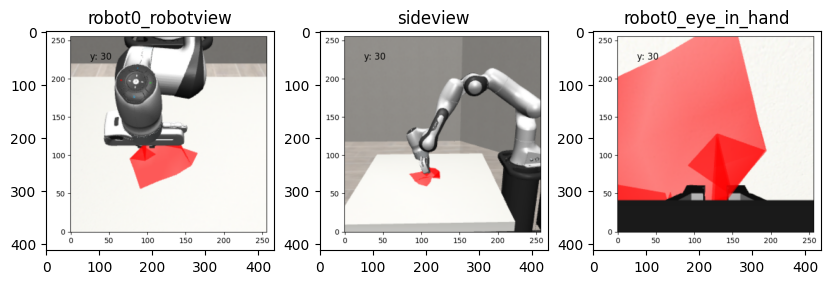

In [21]:
cloth, axis, angle = wrt_num_points.iloc[0].cloth, wrt_num_points.iloc[0].axis, wrt_num_points.iloc[0].angle

draw_images(cloth, axis, angle)

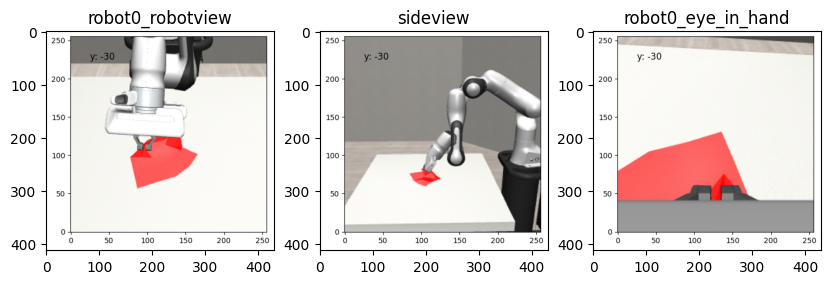

In [22]:
cloth, axis, angle = wrt_num_points.iloc[-1].cloth, wrt_num_points.iloc[-1].axis, wrt_num_points.iloc[-1].angle

draw_images(cloth, axis, angle)

In [23]:
wrt_cvx_vol = df.sort_values(by=['points_cvx_vol'], ascending=False)
wrt_cvx_vol

cloth axis angle  num_points  points_cvx_vol  points_cvx_vol_exists  \
2      25    x   -10           7    2.614489e-06                   True   
11     25    y    10           7    2.499821e-06                   True   
12     25    y    20           7    1.471351e-06                   True   
1      25    x   -20           7    1.343498e-06                   True   
13     25    y    30           8    1.319068e-06                   True   
3      25    x     0           7    1.281844e-06                   True   
10     25    y     0           6    7.381630e-07                   True   
5      25    x    20           6    2.129948e-07                   True   
9      25    y   -10           6    2.050216e-07                   True   
0      25    x   -30           5    8.949164e-08                   True   
4      25    x    10           6    7.026383e-08                   True   
8      25    y   -20           5    5.389910e-08                   True   
6      25    x    30           4    2.946892e-08                   True   
7      25    y   -30           3    0.000000e+00                  False   

    wrench_rank  wench_vol       eps  
2             6   1.305673  0.223040  
11            6   1.185647  0.187862  
12            6   1.209563  0.197915  
1             6   1.164311  0.214621  
13            6   1.420601  0.192037  
3             6   1.240368  0.183510  
10            6   0.914714  0.238689  
5             6   0.780370  0.112913  
9             6   0.970481  0.051861  
0             6   0.842275  0.057674  
4             6   0.627290  0.217224  
8             6   1.001663  0.020334  
6             6   0.541922  0.159212  
7             6   0.200516  0.322834

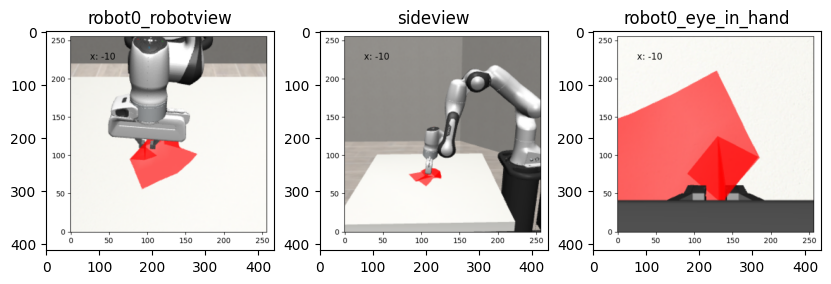

In [24]:
cloth, axis, angle = wrt_cvx_vol.iloc[0].cloth, wrt_cvx_vol.iloc[0].axis, wrt_cvx_vol.iloc[0].angle

draw_images(cloth, axis, angle)

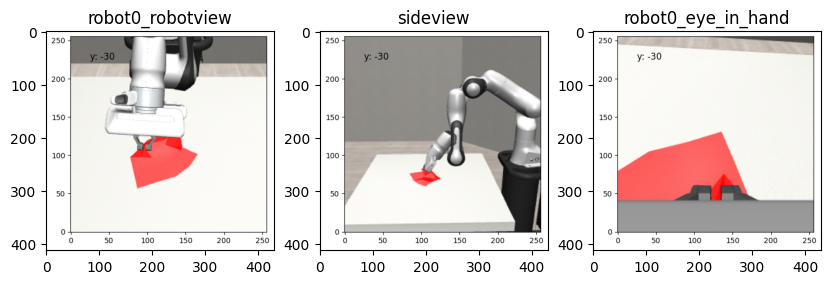

In [25]:
cloth, axis, angle = wrt_cvx_vol.iloc[-1].cloth, wrt_cvx_vol.iloc[-1].axis, wrt_cvx_vol.iloc[-1].angle

draw_images(cloth, axis, angle)

## Volume of covex hull of wrench space

In [11]:
wrt_wrench_vol = df.sort_values(by=['wench_vol'], ascending=False)

In [12]:
wrt_wrench_vol

cloth axis angle  num_points  points_cvx_vol  points_cvx_vol_exists  \
13     25    y    30           8    1.319068e-06                   True   
2      25    x   -10           7    2.614489e-06                   True   
3      25    x     0           7    1.281844e-06                   True   
12     25    y    20           7    1.471351e-06                   True   
11     25    y    10           7    2.499821e-06                   True   
1      25    x   -20           7    1.343498e-06                   True   
8      25    y   -20           5    5.389910e-08                   True   
9      25    y   -10           6    2.050216e-07                   True   
10     25    y     0           6    7.381630e-07                   True   
0      25    x   -30           5    8.949164e-08                   True   
5      25    x    20           6    2.129948e-07                   True   
4      25    x    10           6    7.026383e-08                   True   
6      25    x    30           4    2.946892e-08                   True   
7      25    y   -30           3    0.000000e+00                  False   

    wrench_rank  wench_vol       eps  
13            6   1.420601  0.192037  
2             6   1.305673  0.223040  
3             6   1.240368  0.183510  
12            6   1.209563  0.197915  
11            6   1.185647  0.187862  
1             6   1.164311  0.214621  
8             6   1.001663  0.020334  
9             6   0.970481  0.051861  
10            6   0.914714  0.238689  
0             6   0.842275  0.057674  
5             6   0.780370  0.112913  
4             6   0.627290  0.217224  
6             6   0.541922  0.159212  
7             6   0.200516  0.322834

## Best case with respect to convex hull wrench vol metric

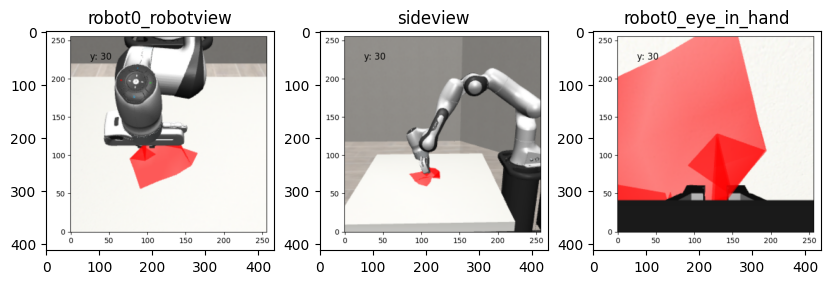

In [13]:
cloth, axis, angle = wrt_wrench_vol.iloc[0].cloth, wrt_wrench_vol.iloc[0].axis, wrt_wrench_vol.iloc[0].angle

draw_images(cloth, axis, angle)

## Worst case with respect to convex hull wrench vol metric

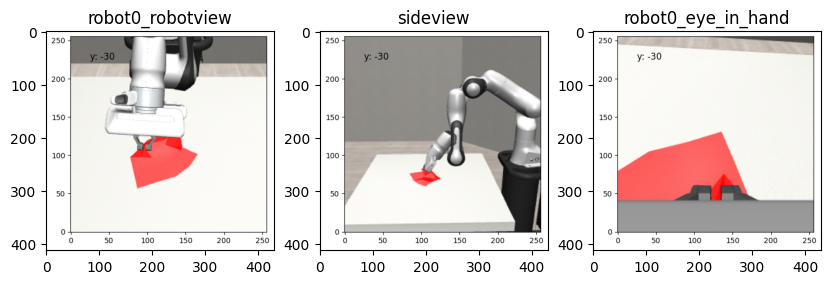

In [14]:
cloth, axis, angle = wrt_wrench_vol.iloc[-1].cloth, wrt_wrench_vol.iloc[-1].axis, wrt_wrench_vol.iloc[-1].angle

draw_images(cloth, axis, angle)

## Espsilon Analysis

In [15]:
wrt_eps = df.sort_values(by=['eps'], ascending=False)

In [16]:
wrt_eps

cloth axis angle  num_points  points_cvx_vol  points_cvx_vol_exists  \
7      25    y   -30           3    0.000000e+00                  False   
10     25    y     0           6    7.381630e-07                   True   
2      25    x   -10           7    2.614489e-06                   True   
4      25    x    10           6    7.026383e-08                   True   
1      25    x   -20           7    1.343498e-06                   True   
12     25    y    20           7    1.471351e-06                   True   
13     25    y    30           8    1.319068e-06                   True   
11     25    y    10           7    2.499821e-06                   True   
3      25    x     0           7    1.281844e-06                   True   
6      25    x    30           4    2.946892e-08                   True   
5      25    x    20           6    2.129948e-07                   True   
0      25    x   -30           5    8.949164e-08                   True   
9      25    y   -10           6    2.050216e-07                   True   
8      25    y   -20           5    5.389910e-08                   True   

    wrench_rank  wench_vol       eps  
7             6   0.200516  0.322834  
10            6   0.914714  0.238689  
2             6   1.305673  0.223040  
4             6   0.627290  0.217224  
1             6   1.164311  0.214621  
12            6   1.209563  0.197915  
13            6   1.420601  0.192037  
11            6   1.185647  0.187862  
3             6   1.240368  0.183510  
6             6   0.541922  0.159212  
5             6   0.780370  0.112913  
0             6   0.842275  0.057674  
9             6   0.970481  0.051861  
8             6   1.001663  0.020334

## Best case with respect to epsilon metric

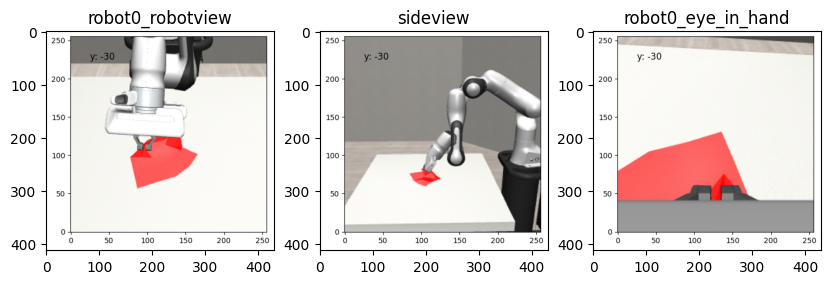

In [17]:
cloth, axis, angle = wrt_eps.iloc[0].cloth, wrt_eps.iloc[0].axis, wrt_eps.iloc[0].angle

draw_images(cloth, axis, angle)

## Worst case with respect to epsilon metric

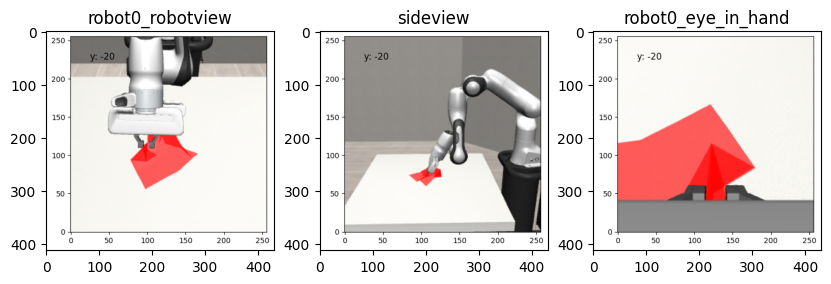

In [18]:
cloth, axis, angle = wrt_eps.iloc[-1].cloth, wrt_eps.iloc[-1].axis, wrt_eps.iloc[-1].angle

draw_images(cloth, axis, angle)